In [159]:
from fastai.tabular import *
from pathlib import Path
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.metrics import accuracy


In [160]:
bs = 32

# Creating a tab+ NLP model 

load previous models 


# NLP model 

In [ ]:
learn_nlp = load_learner('.', 'final_nlp_unigram.pkl')

In [191]:
learn_nlp.model[-1].layers = learn_nlp.model[-1].layers[:-3] 
learn_nlp.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
    )
  )
)

In [199]:
flatten_model(learn_nlp) 

AttributeError: 'RNNLearner' object has no attribute 'children'

## Load tabular learner 

In [163]:
learn_tab = load_learner('.','final_tab.pkl')

In [164]:
learn_tab

Learner(data=TabularDataBunch;

Train: LabelList (0 items)
x: TabularList

y: CategoryList

Path: .;

Valid: LabelList (0 items)
x: TabularList

y: CategoryList

Path: .;

Test: None, model=TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(1997, 113)
    (2): Embedding(279, 37)
    (3): Embedding(56, 15)
    (4): Embedding(13, 7)
    (5): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.05, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=177, out_features=446, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(446, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=446, out_features=24, bias=True)
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=LabelSmoothingCrossEntropy(), metrics=[<function accuracy at 0x7fcd30

# Grab up to ReLU

In [165]:
learn_tab.model.layers = learn_tab.model.layers[:-3]
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(1997, 113)
    (2): Embedding(279, 37)
    (3): Embedding(56, 15)
    (4): Embedding(13, 7)
    (5): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.05, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=177, out_features=446, bias=True)
    (1): ReLU(inplace=True)
  )
)

# Concat dataset

In [166]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): 
        self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]



# Load datasets

In [167]:
data_tab = load_data('.','tab_data')
data_nlp = load_data('.', 'nlp_data')

# Create ConcatDatasets for tab and NLP 

In [168]:
train_ds = ConcatDataset(data_tab.train_ds.x, data_nlp.train_ds.x, data_tab.train_ds.y)
valid_ds = ConcatDataset(data_tab.valid_ds.x, data_nlp.valid_ds.x, data_tab.valid_ds.y)

In [169]:
# 

In [170]:
def collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

In [171]:

#Go through the text data by order of length with a bit of randomness.
train_sampler = SortishSampler(data_nlp.train_ds.x, key=lambda t: len(data_nlp.train_ds[t][0].data), bs=bs//2)

# Go through the text data by order of length.
valid_sampler = SortSampler(data_nlp.valid_ds.x, key=lambda t: len(data_nlp.valid_ds[t][0].data))

In [172]:
train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=collate, path='.')

In [173]:
(x1,x2),y = next(iter(data.train_dl))
print(f'Shape tabular batch (cats/cont): {x1[0].shape} / {x1[1].shape}')
print(f'Shape nlp batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape tabular batch (cats/cont): torch.Size([16, 6]) / torch.Size([16])
Shape nlp batch: torch.Size([16, 125])
Shape dependent var: torch.Size([16])


In [174]:
class ConcatModel(nn.Module):
    def __init__(self, model_tab, model_nlp, layers, drops): 
        super().__init__()
        self.model_tab = model_tab
        self.model_nlp = model_nlp
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs): 
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn) # https://docs.fast.ai/layers.html#bn_drop_lin
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.model_tab(*x[0])
        x_nlp = self.model_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)   

## Layer groups 

Layer groups allow us to use the fastai freeze layers approach to train some layers more or turn off training on some layers. 

```flatten_model``` allows you to acccess the model as an array making it easy to grab the bits you want

In [175]:
m = simple_cnn([3,6,12])
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

In [176]:
m[0]

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
)

In [177]:
print(flatten_model(m)[0])
print('-*-')
print(flatten_model(m)[1])


Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
-*-
ReLU(inplace=True)


In [178]:
lin_layers = [446+50, 24]
ps = [0.8]
model = ConcatModel(learn_tab.model, learn_nlp.model, lin_layers, ps)
model

ConcatModel(
  (model_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(1997, 113)
      (2): Embedding(279, 37)
      (3): Embedding(56, 15)
      (4): Embedding(13, 7)
      (5): Embedding(2, 2)
    )
    (emb_drop): Dropout(p=0.05, inplace=False)
    (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=177, out_features=446, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (model_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(10000, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(10000, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1152, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1152, 1152, batch_first=True)
          )
          (2)

In [205]:
layer_groups = [nn.Sequential(*flatten_model(learn_nlp.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[3])),
                nn.Sequential(*(flatten_model(learn_nlp.layer_groups[4]) + 
                                flatten_model(model.mod_tab) +
                                flatten_model(model.layers)))] 

IndexError: list index out of range

In [210]:
loss_func = nn.CrossEntropyLoss()

In [211]:
learn = Learner(data, model, loss_func=loss_func, metrics=accuracy) #layer_groups=layer_groups)

In [212]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


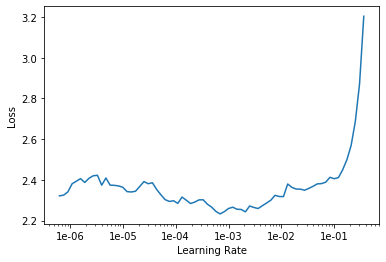

In [214]:
learn.recorder.plot()

In [215]:
learn.fit_one_cycle(20,max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,2.330485,2.069864,0.387237,01:33
1,2.053699,1.981569,0.386242,01:41
2,2.061845,2.026175,0.385744,01:42
3,2.014821,1.950073,0.389228,01:38
4,1.982271,1.868321,0.393706,01:32
5,2.002954,2.013082,0.381142,01:41
6,2.018170,1.900823,0.399055,01:35
7,2.006381,1.907025,0.394701,01:42
8,1.978006,1.897711,0.394825,01:42
9,1.941316,1.875527,0.399303,01:33


In [216]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


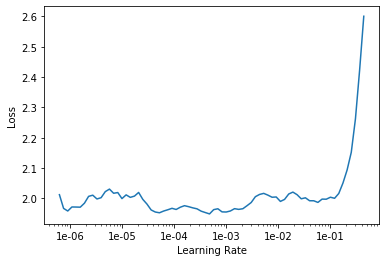

In [217]:
learn.recorder.plot()

In [221]:
learn.fit_one_cycle(20, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.889814,1.876748,0.401169,01:33
1,1.919403,1.814113,0.403533,01:36
2,1.927863,1.817977,0.406518,01:33
3,1.922724,1.805486,0.400423,01:40
4,1.924135,1.837712,0.403533,01:30
5,1.938889,1.859075,0.399677,01:31
6,1.973737,1.832615,0.401045,01:44
7,1.908813,1.824516,0.404155,01:31
8,1.904674,1.839937,0.401542,01:33
9,1.972765,1.817892,0.404030,01:34
